<img style="float: right" src="images/surfsara.png"><hr style="clear: both" />

## TODOs
1. Move functions from notebook to package (also move download to package import)
1. Sexier plotting of images
1. Show statistics about classes, image size
1. Explanation of what to look for when spotting pneumonia, show bigger image as well
1. Explanation of hyperparameters
1. Explanation about batch size
1. Explanation about softmax
1. Remove functional API
1. Explanation of cross-entropy
1. Explanation of Adam
1. Remove F1, only use accuracy
1. Wrap model training into function, outputting statistics, conf. matrix and plots
1. First dense model should not need 100 epochs
1. Explain validation vs test set
1. Make looking at dense layer weights an exercise
1. Rotate images beforehand, not at training level
1. Simplify convolution explanation
1. Explanation of under-/overfitting
1. Explanation of rationale behind max-pooling, esp. in relation to rotations
1. Explanation of first CNN
1. Look at learning rates
1. Does the CNN perform better on instances misclassified by the dense network?
1. Do zero hidden layers make any sense?
1. Reproducibility of results?
1. Move up layer/feature map visualisation, before rotations
1. Exercises: thought exercises and tinkering with networks
  1. Network complexity
1. Reduce computation time for network used for visualisation

# Crash course in Deep Learning

In this notebook we will give a crash course in Deep Learning. First the we will introduce dense networks and then move to Convolutional Neural Networks (CNNs). Most deep learning models are composed of many induvidual components and  these two serve well to classify images.

After finishing this notebook you should have a general understanding of the layers and activations most commonly seen in CNNs. You should also have a good idea of how they interract with each other.

## Data

We will be working with a [chest x-ray dataset](https://data.mendeley.com/datasets/rscbjbr9sj/2). Using the dataset, our goal is to correctly classify images in the dataset as to whether they contain pneumonia or not. That is, we want to perform classification.

In the next cell we download a preprocessed (by us) subset of the data. We have preprocessed the data so that the images are smaller. This allows quicker processing at cost of less information present in the images. 

In [1]:
import lib

lib.download_data()
normal_images, pneumonia_images = lib.print_dataset_statistics()

The dataset is balanced
Training set, normal examples:  1267
Training set, pneumonia examples:  1267
The dataset is split 80% train /20% test.
Test set, normal examples:  316
Test set, pneumonia examples:  316
split =  0.1996209728363866


We have made sure that our dataset contains equally many examples of pneumonia cases and normal cases. This does not reflect reality (as most x-rays are not x-rays of pneumonia cases) but it makes the evalution of the model simpler.

Let us look at some of these images

In [2]:
%matplotlib inline

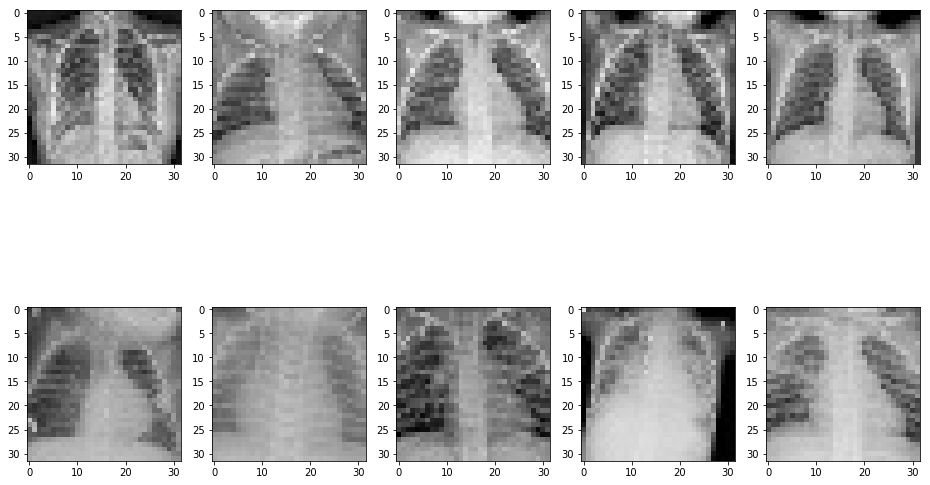

In [3]:
lib.show_images(normal_images[:5] + pneumonia_images[:5])

We can, roughly, see on these images that pneumonia cases contain more "white" in the lung area. Hopefully, we can create a neural network which can extract a more useful feature and solve the task better.

We will be using [Keras](https://keras.io/) "... a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano." We will use the Keras API to define the architecture of our network, which is then implemented in [TensorFlow](https://www.tensorflow.org/).

As a first step we need to prepare the data for our neural network. This includes scaling all pixel values to values between 0 and 1 and defining a validation dataset split. We let Keras take care of this for us.

In [4]:
import keras

INPUT_SHAPE = (32, 32)
gen = keras.preprocessing.image.ImageDataGenerator(validation_split=0.2,
                                                   rescale=1./255)
# target_size, all images will be resized to this size
train_batches = gen.flow_from_directory("selection/train",        # our data is in this folder
                                        target_size=INPUT_SHAPE,  # all images will be scaled to this size 
                                        class_mode="categorical", # tells Keras to treat the folders as classes
                                        color_mode="grayscale",   # only 1 dimension of pixel values (32, 32, 1)
                                        batch_size=32,            # compute the gradient every 32 images
                                        subset="training")        # training set

validation_batches = gen.flow_from_directory("selection/train",   # same folder
                                        target_size=INPUT_SHAPE,
                                        class_mode="categorical",
                                        color_mode="grayscale",
                                        batch_size=32,
                                        subset="validation")      # but use a subset for validation
test_batches = gen.flow_from_directory("selection/test",
                                       target_size=INPUT_SHAPE,
                                       class_mode="categorical",
                                       shuffle=False,             # Do not shuffle the data
                                       color_mode="grayscale", 
                                       batch_size=1)              # evaluate 1 image at a time


Using TensorFlow backend.


Found 2028 images belonging to 2 classes.
Found 506 images belonging to 2 classes.
Found 632 images belonging to 2 classes.


As you can see, the default backend for Keras is TensorFlow.

## Layers

In Keras each **layer** in a network is a logical collection of functions applied to the input and return some output. The input are the activations of other neurons and the output is the activation of the neurons in output layer. The layers are the *meat* of the network. The composition of layers and a loss functions defines a neural network architecture.
Most layers change the dimension of the data, by either "compressing" the input information or "uncompress" it.
The first two layers we explore are the **dense** and **softmax** layers.

### Dense

A dense layer is defined by a matrix $W$ and vector $b$. $W$ is called the weight matrix and $b$ the bias. Lets assume that $W$ is a $n \times m$ matrix and $b$ a $n$-dimensional vector. Given an $m$-dimensional input vector $x$ the output of a dense layer is $y = Wx + b$. Or for each $y_i$ where $i \in n$, $y_i = \sum_j  x_j w_{i,j}+b_i$.

**Think:** What is the output of a dense layer given a black image (all $x_i = 0$)? Is the output then the same as if all the weights where 0?

### Softmax

The output of a node in a dense layer is some real ($\mathbb{R}$) value and sometimes we want to limit the range of the output nodes. This can be done through **activations**. An activation on a node is meant to change the output range of the node. **Softmax** is one such activation which changes the output so that it can be interpreted as a probability distribution.

The softmax layer has two components. First there is normalization. Given input $x$ the output of the softmax layer is $y = x \frac{1}{|x|}$ or $y_i = \frac{x_i}{\sum_j x_j }$. But this poses problems when dealing with both positive and negative values (they potentially cancel out) as well as the fact that not all $y_i \ge 0$. The second component addresses this issue by mapping all the values to $[0;\infty]$. We use the exponential function for this $f(x)=e^x$. By doing this we are effectively interpreting negative values as representing something 'very unlikely' and positive values as something 'more likely'. We apply the normalization after the second component resulting in:
$$y_i=\frac{e^{x_i}}{\sum_j e^{x_j}}$$
Thus, every $y_i \geq 0$ and $\sum_i y_i = 1$ and we can interpret the output as a probability distribution over $n$ different classes, i.e. at $y_i$ the output is $'P(y=i|x)'$. 
To explain this a bit further it is important to understand that $n$ classes are often represented using an $n$-dimensional vector of 0s and 1s. This representation is called 'one-hot encoding' and is also used to represent words in DL. In our classification task we use a two dimensional vector where the first dimension represents the class of being 'not pneumonia' and the other dimension as containing 'pneumonia'.

**Think:** What would the vector $[1,0]^T$ represent? What about  $[0.5, 0.5]^T$? Would the vector $[0,0]^T$ be legal according to softmax?

Let us now define simple neural network as our baseline in our classification task.

In [5]:
# Each layer is processed in sequence
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten
from keras.optimizers import Adam

model = Sequential()
# We first 'flatten' the data, i.e. interpret it as a single vector instead of as a matrix or a tensor.
# We can do this safely as dense layers are not dependent on the ordering or the structure of the input.
model.add(Flatten(input_shape=train_batches.image_shape))
model.add(Dense(2)) # 2 is the output dimension, i.e. two output nodes.
model.add(Activation("softmax")) # we interprete the two nodes as probabilities over two classes.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 2,050
Trainable params: 2,050
Non-trainable params: 0
_________________________________________________________________


The image we feed into the network is $32 \times 32 = 1024$ pixels as we can see after the 'flatten' layer.

**Think:** Try figuring out where all 2050 parameters from the dense layer come from and what they represent.

## Cross entropy loss

Interpreting the output as a probability distribution is all fine and well, but we want the distribution to be meaningful and be learnt from the data. To establish this we need to train the model and we do this using a loss function which operates on the output of the network, in our case the softmax layer. This is the **cross entropy** loss. The name is very technical and a full explaination would involve some information theory which we will skip at this point. Instead we offer a more intuitive explaination of the loss.

For every input the model produces a vector $\hat y$ and according to the training data we have the correct $y$.
Recall in the previous section about softmax we used $y$ to represent classes using one-hot encoding, furthermore, softmax outputs a probability distribution over all the classes.
These facts allow us to only consider the loss w.r.t. a single element in $\hat y$, the correct class.
Consider this example to get a better understanding why:

$y=[0.0, 0.0, 1.0]^T$ and $\hat y=[0.2, 0.3, 0.5]^T$. The correct prediction is class #3, i.e. $y_3$ should be 1.0. Lets use a basic loss, for example the difference (distance, norm), we get $|y- \hat y|=0.2+0.3+0.5=1.0$. We want to minimize this loss by adjusting $\hat y$. To do this we ONLY need to increase $y_3$, this will decrease $y_1$ and $y_2$ because we normalize in the softmax layer.

This means that we only need to compute the loss w.r.t. the correct element of $y$.
But what is wrong with using the simple loss which we used above ($|y- \hat y|$)?
If the loss is zero, $y=\hat y$, if the loss is 1 then $y$ and $\hat y$ have the opposite values. This loss seems to do the trick, but alas, it does not do well in practice for many reasons (f.ex. it is numerically unstable and is linear). We also want to make our loss to capture the fact that the difference of loss going from 0.8 to 0.7 is more valuable than the change from 0.2 to 0.1. That is, we want to emphasize that 'very incorrect' predictions are 'very bad'. Thus we want the loss to treat steps unequally. The change in loss going from from 0.8 to 0.7 should not be equal to the change from 0.2 to 0.1. This is done by mapping the loss to a range of $[0,\infty]$ using $-\log (1-|y-\hat y|)$.

We already mentioned that we only need to compute the loss w.r.t. the correct element so we treat everything in $-\log (1-|y-\hat y|)$ as a scalar where $y=1$, thus, $-\log (1-|y-\hat y|)=-\log (1-|1-\hat y|)=-\log (\hat y)$.

Furthermore, the log helps with numerical stability.

For a more detailed explaination we refer to the extra material found at the bottom of the notebook.

Now we can finally train our simple model!

In [6]:
model.compile(Adam(lr=0.0001),
              loss="categorical_crossentropy", 
              metrics=["accuracy"])
history = model.fit_generator(train_batches, validation_data=validation_batches, epochs=50)

Epoch 1/50
64/64 [==============================] - 2s 24ms/step - loss: 0.7497 - acc: 0.4116 - val_loss: 0.7123 - val_acc: 0.4921
Epoch 2/50
64/64 [==============================] - 1s 21ms/step - loss: 0.6806 - acc: 0.5903 - val_loss: 0.6583 - val_acc: 0.6640
Epoch 3/50
64/64 [==============================] - 1s 22ms/step - loss: 0.6289 - acc: 0.7305 - val_loss: 0.6148 - val_acc: 0.7628
Epoch 4/50
64/64 [==============================] - 1s 21ms/step - loss: 0.5830 - acc: 0.8138 - val_loss: 0.5739 - val_acc: 0.7905
Epoch 5/50
64/64 [==============================] - 1s 21ms/step - loss: 0.5447 - acc: 0.8397 - val_loss: 0.5392 - val_acc: 0.8083
Epoch 6/50
64/64 [==============================] - 1s 22ms/step - loss: 0.5119 - acc: 0.8549 - val_loss: 0.5108 - val_acc: 0.8182
Epoch 7/50
64/64 [==============================] - 1s 22ms/step - loss: 0.4849 - acc: 0.8576 - val_loss: 0.4873 - val_acc: 0.8340
Epoch 8/50
64/64 [==============================] - 1s 22ms/step - loss: 0.4622 - a

632/632 [==============================] - 1s 1ms/step
F1 score 0.890625
Accuracy 0.8892405063291139


NameError: name 'sklearn' is not defined

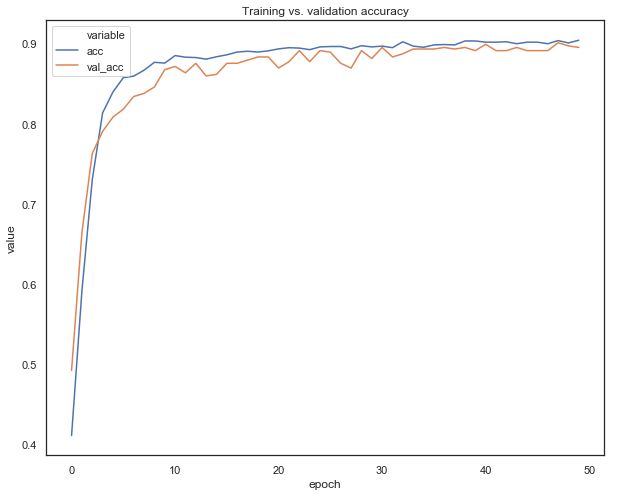

In [7]:
lib.report_model(model, history, test_batches)

Wow! Our model is doing quite well! It's able to classify a lot of these images correctly. 
Let us take a closer look on the weights the model has trained. 

**Think** Try to make sense of the following images. What do the positive and negative weight values stand for?

In [ ]:
lib.show_flat_weights(model)

**Think** Try changing the learning rate and see how it affects the training.

## Hidden layers

Let us now introduce an additional layer before the softmax layer. A layer between the input layer and output layer is called a **hidden layer**. Hidden layers serve as feature extractors. A node in a hidden layer should fire (have value different than 0) when it detects a pattern. The pattern could be that 'these particular 5 pixels are white and these two are black and others can be anything'. Additionally, we don't want the feature detector to indicate to us when the pattern is not present. We get the desired behaviour by using a dense layer as a hidden layer and using the ReLU activation.

**Think:** How does the dense layer detect the pattern mentioned?

### ReLU

The **ReLU** activation is simply the function $y=\max(0,x)$. We could have also used a more elegant, and smooth, function from the **sigmoid** family of functions, but in practice ReLU allows training of deeper network.

**Think:** Why is the ReLU function better for training deeper networks? What happens to the error when it passes through many layers using a sigmoid function vs. a ReLU? How does the gradient look like for these functions?

In the network defined below we define a hidden layer with 32 nodes, that is, 32 (global) feature detectors.

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=train_batches.image_shape))
model.add(Dense(32)) # The hidden layer
model.add(Activation("relu"))
model.add(Dense(2)) # We still need to do this
model.add(Activation("softmax")) # we interprete the two nodes as probabilities over two classes.
model.summary()

**Think:** Again, think where all the parameters are coming from.

In [ ]:
model.compile(Adam(lr=0.0001),
              loss="categorical_crossentropy", 
              metrics=["accuracy"])
history = model.fit_generator(train_batches, validation_data=validation_batches, epochs=50)
lib.report_model(model, history, test_batches)

**Think:** What would it mean if we stack another hidden layer after the first hidden layer? Try it out in the next block.

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=train_batches.image_shape))
model.add(Dense(32)) 
model.add(Activation("relu"))
model.add(Dense(2)) 
model.add(Activation("softmax"))
model.summary()

model.compile(Adam(lr=0.0001),
              loss="categorical_crossentropy", 
              metrics=["accuracy"])
history = model.fit_generator(train_batches, validation_data=validation_batches, epochs=50)
lib.report_model(model, history, test_batches)

Here it would be nice to have pictures of the activations.

## Convolutional Neural Networks (CNN)

So what is wrong with with the above approach? Why can't we just use dense layers 'all the way down' to classify images? There are a number of issues which surface when attempting this approach.
1. The learnt features are bound to a location on the image. This implies that they are not rotation invariant and translation invariant.
1. There are a lot of parameters involved. Especially with larger images.

Convolutional neural networks address these problems by introducing two new layers.

### Convolutional layer

![filters](images/filters.gif)
(Source:  Stanford CS class CS231n: Convolutional Neural Networks for Visual Recognition) In this image we see that stride (2,2) is used.

A convolutional layer defines a number of kernels/filters.
A kernel is defined by a matrix $K$ and is applied (using a dot product, plus bias) to an area on the image.
The output, a single scalar value is stored in a output matrix.
The kernel is applied many times to the image, shifting (stride) after each application, starting from the top left position and stops at the bottom right, filling the output matrix.

A ReLU activation is then applied to the output matrix.

The idea is that $K$ is some pattern detector which traverses the image and records the activations of that pattern. Common patterns detectors which emerge from the first layers of a CNN are edge detectors and dot detectors. These then combine in later layers to compose more complex patterns.

### Pooling

![maxpool](images/maxpool.jpeg)
(Source: Stanford CS class CS231n: Convolutional Neural Networks for Visual Recognition). In this image we see a pool size of (2,2) (red, green, yellow, blue) with stride (2,2) using the max function.

A pooling layer is defined by a single function which takes a matrix as input and outputs a single scalar, very much like a kernel, but contains no parameters.
A pooling layer is meant to locally downsample the input matrix. The most common pooling layer (which we use) is Max Pooling which uses the $\max$ function.
The pooling kernel is applied just like convolutional kernel.

In the above  Usually pooling layers use the same size for strides and pool size.

### A simple CNN

Now we want to define a simple CNN.
To do this we need to combine all of the layers mentioned above.

In [4]:
from keras.layers import Conv2D, MaxPooling2D, Reshape

model = Sequential()
model.add(Conv2D(filters=16,
                 kernel_size=(3, 3),
                 padding="valid",
                 input_shape=train_batches.image_shape))
model.add(Activation("relu"))
model.add(Conv2D(filters=16,
                 kernel_size=(3, 3),
                 padding="valid",
                 input_shape=train_batches.image_shape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(2))
model.add(Activation("softmax"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 16)        160       
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
activation_3 (Activation)    (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 6274      
__________

Notice how the conv layers change the dimensions of the data.
First we see a reduction from (32,32) to (30,30). Why is this?
Secondly, 16 new slices are added after the first layer. What do these new slices reflect?

**Think**: Try figuring out where all the parameters in the model come from. The second conv layer is tricky.

Hint: The first layer is has $w \times h \times d \times n + n$ where $n$ is the number of filters.

In [ ]:
model.compile(Adam(lr=0.00001),
              loss="categorical_crossentropy", 
              metrics=["accuracy"])
history = model.fit_generator(train_batches, validation_data=validation_batches, epochs=50)

In [ ]:
lib.report_model(model, history, test_batches)

## Visualizing kernels and intermediate layers

Visualizing the activations after the convolutional layers can be helpful in understanding how CNNs works. Notice that the following visualizations are based on the *activations* of some input after training. This gives us an indication of what patches/sections of the image are thought to be the most relevant during classification.

In [ ]:
model = Sequential()

# Block 1

model.add(Conv2D(filters=32,
                 kernel_size=(3, 3),
                 padding="valid",
                 input_shape=train_batches.image_shape))
model.add(Conv2D(filters=32,
                 kernel_size=(3, 3),
                 padding="valid"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

# Block 2

model.add(Conv2D(filters=64,
                 kernel_size=(3, 3),
                 padding="valid"))
model.add(Conv2D(filters=64,
                 kernel_size=(3, 3),
                 padding="valid"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

# Dense block

model.add(Flatten())

model.add(Dense(32))
model.add(Activation("relu"))
model.add(BatchNormalization())

model.add(Dense(2))
model.add(Activation("softmax"))

model.summary()
model.compile(Adam(lr=0.00001),
              loss="categorical_crossentropy", 
              metrics=["accuracy"])
history = model.fit_generator(train_batches, validation_data=validation_batches, epochs=20)

In [ ]:
# Intermediate output

intermediates = Model(inputs=model.input, outputs=[
    model.layers[0].output,
    model.layers[2].output,
    model.layers[4].output,
    model.layers[8].output
])

In [ ]:
intermediate_outputs = intermediates.predict_generator(test_batches)
for i, o in enumerate(intermediate_outputs):
    print('{}: {}'.format(i, o.shape))

### Images after first convolution, *before* second convolution and activation

In [ ]:
lib.plot_images(np.rollaxis(intermediate_outputs[0][50], axis=2))

### Kernels at first layer

We can also visualize the weights of learnt kernels, which should reflect some visual features (dots, lines in the first layers).

In [ ]:
lib.plot_images(
    np.rollaxis(model.layers[0].get_weights()[0], axis=3).squeeze(),
    ncols=16
)
plt.tight_layout()

### Images after second convolution and activation

In [ ]:
lib.plot_images(np.rollaxis(intermediate_outputs[1][50], axis=2))

### Feature maps after second block of convolutions

In [ ]:
lib.plot_images(np.rollaxis(intermediate_outputs[2][50], axis=2))

### Feature maps before going into dense layer

In [ ]:
lib.plot_images(np.rollaxis(intermediate_outputs[3][50], axis=2))

## Kernels at second layer

In [ ]:
lib.plot_images(
    np.rollaxis(model.layers[5].get_weights()[0], axis=3).squeeze(),
    ncols=16
)
plt.tight_layout()

## More material
- [Standford's course](https://cs231n.github.io/)
- [Google's crash course](https://developers.google.com/machine-learning/crash-course)
- [Blog](http://ruder.io/optimizing-gradient-descent/) explaining different versions of GD well.